# Machine Learning Projekt - Gruppe 9
## Projekt: _Electric Motor Temperature Estimation_
### SS2025

Gruppenmitglieder: André Korten, Fynn Buhl, Kilian Feil, Lukas Quast, Nic Tusch, Tobias Weismantel
____

## Aufgabenstellung:

Aufgabe des Projekts ist es, auf Grundlage des vorliegenden Datensatzes die Temperatur des Permanentmagneten eines datas vorherzusagen.
Zur Umsetzung dieser Regressionsaufgabe werden zwei vorgegebene Verfahren eingesetzt: Random Forest sowie ANN. Zusätzlich wird ein drittes, selbst gewähltes Verfahren zur Modellierung und zum Vergleich herangezogen.




&nbsp;


### 1. Frame the Problem and Look at the Big Picture
1. Zielsetzung:
Aus den Messwerten vom Spannung U und Strom I der jeweiligen d- bzw. q-Achse die Temperatur des Permanent-Magneten vorherzusagen. Um ggf. zu hohe Temperatruren vor der Schadensentstehung zu erkennen.

__Business Objektive???__

2. Leistungsbewertung (Performance Measuremant):
Root Mean Square Error, weil es der Standard für Regressionprobleme ist und nur von wenigen Ausreißern in den Daten ausgegangen wird.

__Zielwert/Minimierung???__


3. Bisheriger Lösungsansatz:
Aktuell werden die Temperaturen über Thermokoppler gemessen. Regelbasiter Algorithmus reagiert nachgelagert auf Temperaturänderungen und drosselt die Leistung ggf.


4. Annahmen:
* supervised learning, da gelabelte Trainingsdaten vorliegen
* offline, batch learning, da alle Daten in den Speicher passen und kein kontinuirlicher Datenstrom erwartet wird
* multiple regression task, da mehrer Feature zur Vorhersage verwendet werden
* univariate regression, da nur ein einziger Wert vorhergesagt wird
* 2 Hz Abtastrate der Daten
* Aufnhame in wechiedenen Session (1-6h), zuordnung über profil_id
* alle Relevanten Feature sind vorhanden
* wenig Aussreißer in den Daten
* Vollständiger Datensatze
* aussschließlich nummerische Messwerte
* Motor ist immer heil geblieben



    

### 2. Get the Data

**Kontext**

Der Datensatz umfasst verschiedene Sensordaten, die von einem Permanentmagnet-Synchronmotor (PMSM) auf einem Prüfstand gesammelt wurden. Bei dem PMSM handelt es sich um den Prototyp eines deutschen OEMs. Die Prüfstandsmessungen wurden von der Abteilung LEA der Universität Paderborn durchgeführt.


**Inhalt**

Alle Aufzeichnungen werden mit 2 Hz abgetastet. Der Datensatz besteht aus mehreren Messsitzungen, die durch die Spalte „profile_id“ voneinander unterschieden werden können. Eine Messsitzung kann zwischen einer und sechs Stunden lang sein.

Der Motor wird durch von Hand entworfene Fahrzyklen erregt, die eine Referenzmotordrehzahl und ein Referenzdrehmoment vorgeben.
Die Ströme in d/q-Koordinaten (Spalten „i_d“ und i_q„) und die Spannungen in d/q-Koordinaten (Spalten ‚u_d‘ und “u_q") sind das Ergebnis einer Standardregelstrategie, die versucht, der Solldrehzahl und dem Solldrehmoment zu folgen.
Die Spalten „motor_speed“ und „torque“ sind die resultierenden Größen, die durch diese Strategie erreicht werden, abgeleitet von den eingestellten Strömen und Spannungen.

Die meisten Fahrzyklen stellen Zufallsbewegungen in der Drehzahl-Drehmoment-Ebene dar, um die realen Fahrzyklen genauer zu imitieren, als dies bei konstanter Erregung und Hoch- und Herunterfahren der Fall wäre.


Quelle: _https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature_


In [113]:
# import required packages for the hole project
import os
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [99]:
# Define the path where the data file is stored
DATA_PATH = "./"

# Function to load motor data from a CSV file
def load_motor_data(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "measures_v2.csv") #CSV file has a header row -> Default: Assumes that the first row is the header
    return pd.read_csv(csv_path)

# Load the motor dataset using the defined function
data = load_motor_data(DATA_PATH)

# Display information about the loaded DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


~1,3 Mio Einträge, keine leeren Werte, nur zahlen (float / integer) --> no fill of missing & no enconding

In [100]:
data.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


das sagt uns ....
standartisiern

In [101]:
data.describe()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
count,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06
mean,5.427900e+01,3.622999e+01,6.634275e+01,-2.513381e+01,5.687858e+01,2.202081e+03,-6.871681e+01,3.741278e+01,5.850678e+01,4.818796e+01,2.456526e+01,3.110603e+01,4.079306e+01
std,4.417323e+01,2.178615e+01,2.867206e+01,6.309197e+01,2.295223e+01,1.859663e+03,6.493323e+01,9.218188e+01,1.900150e+01,1.999100e+01,1.929522e+00,7.713575e+01,2.504549e+01
min,-2.529093e+01,1.062375e+01,1.858582e+01,-1.315304e+02,1.813398e+01,-2.755491e+02,-2.780036e+02,-2.934268e+02,2.085696e+01,1.807669e+01,8.783478e+00,-2.464667e+02,2.000000e+00
25%,1.206992e+01,1.869814e+01,4.278796e+01,-7.869090e+01,3.841601e+01,3.171107e+02,-1.154061e+02,1.095863e+00,4.315158e+01,3.199033e+01,2.318480e+01,-1.374265e-01,1.700000e+01
50%,4.893818e+01,2.690014e+01,6.511013e+01,-7.429755e+00,5.603635e+01,1.999977e+03,-5.109376e+01,1.577401e+01,6.026629e+01,4.562551e+01,2.479733e+01,1.086035e+01,4.300000e+01
75%,9.003439e+01,4.985749e+01,8.814114e+01,1.470271e+00,7.558668e+01,3.760639e+03,-2.979688e+00,1.006121e+02,7.200837e+01,6.146083e+01,2.621702e+01,9.159718e+01,6.500000e+01
max,1.330370e+02,1.015985e+02,1.413629e+02,1.314698e+02,1.119464e+02,6.000015e+03,5.189670e-02,3.017079e+02,1.136066e+02,1.011480e+02,3.071420e+01,2.610057e+02,8.100000e+01


das sagt uns....

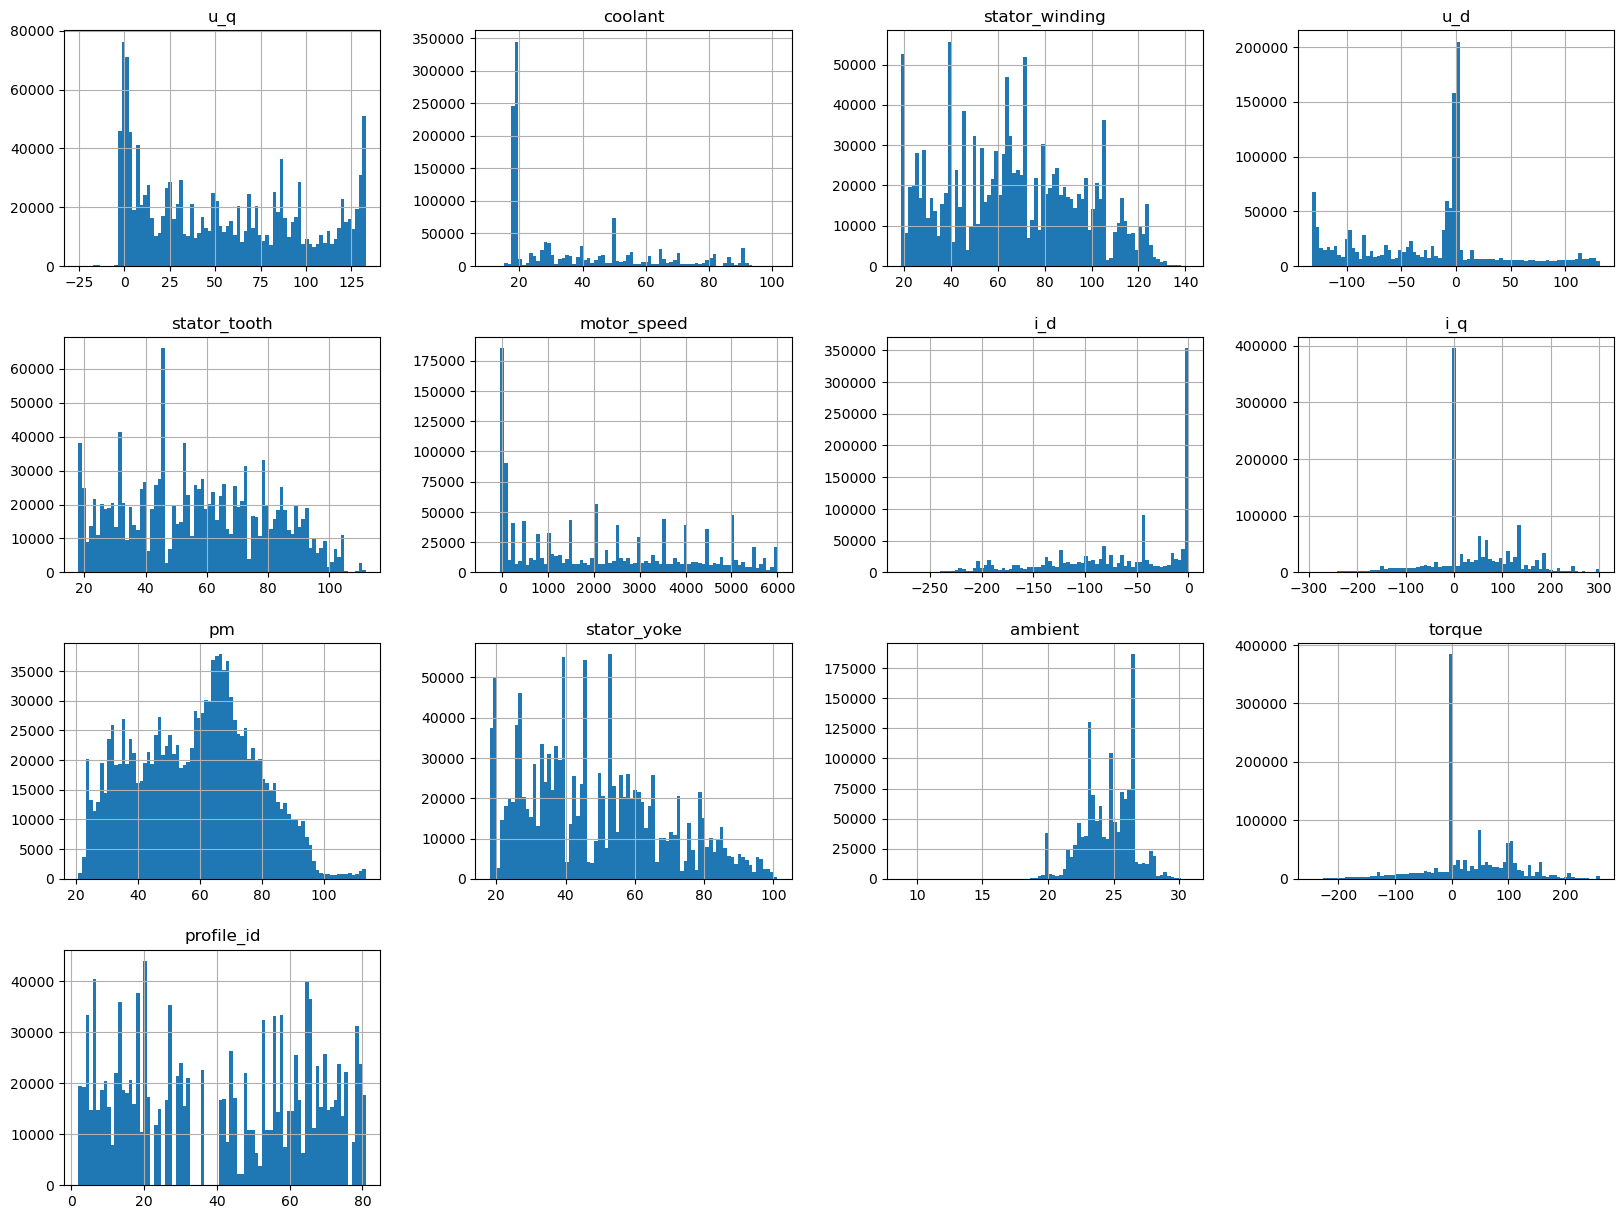

In [102]:
data.hist(bins=80, figsize=(20,15))
plt.show()

komische striche, ggf. null ausschließen - motor aus

count    1.330816e+06
mean     4.079306e+01
std      2.504549e+01
min      2.000000e+00
25%      1.700000e+01
50%      4.300000e+01
75%      6.500000e+01
max      8.100000e+01
Name: profile_id, dtype: float64


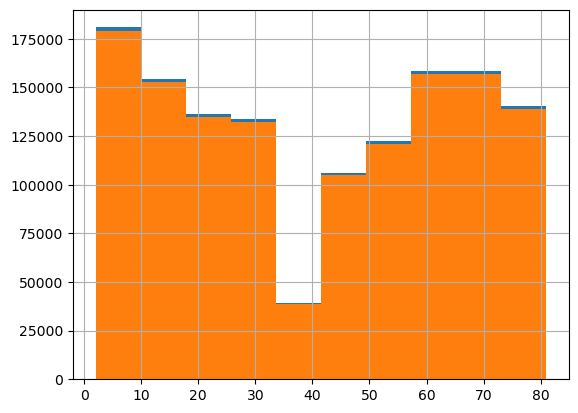

In [103]:
# sample a stratifed test set from all sessions (multible mesaurements can be distinguisht from each other by column profile_id)
print(data["profile_id"].describe())
data["profile_id"].hist()

#1% Testsetsize , due to >100.000 Datapoints
split = StratifiedShuffleSplit(n_splits=1, test_size=0.01, random_state=42)
for train_index, test_index in split.split(data, data["profile_id"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
    
    
strat_train_set["profile_id"].hist()
#Verify that the stratified test set (orange) preserves the same distribution shape as the full dataset (blue), 
#but with ~99% of the sample size (i.e., lower bars with identical relative frequencies).
plt.show()

### 3. Explore the Data

1. Create a copy of the training set for exploration (sample it down to a manageable size if necessary).
* data = df.copy()
2. (Create a Jupyter Notebook for your data exploration.)
3. Study each attribute and its characteristics
    - name
    - type
    - % of missing values
    - noisiness
    - usefulness for task
    - type of distribution
    - ...
4. Identify the target attribute (supervised learning).
5. Visualize the data.
6. Study correlations between attributes.
7. Identify the promising transformations you may want to apply.
8. Document the results of your exploratory data analysis.

In [104]:
# copy of the training set
motor = strat_train_set.copy()

Zielattribut: pm - permanetmagnet temperatur

In [105]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
#from pandas.plotting import scatter_matrix

#attributes = ["pm", "u_q","coolant","stator_winding","u_d","stator_tooth","motor_speed","i_d","i_q","stator_yoke","ambient","torque"]
#scatter_matrix(motor[attributes], figsize=(12, 8))
#plt.show()

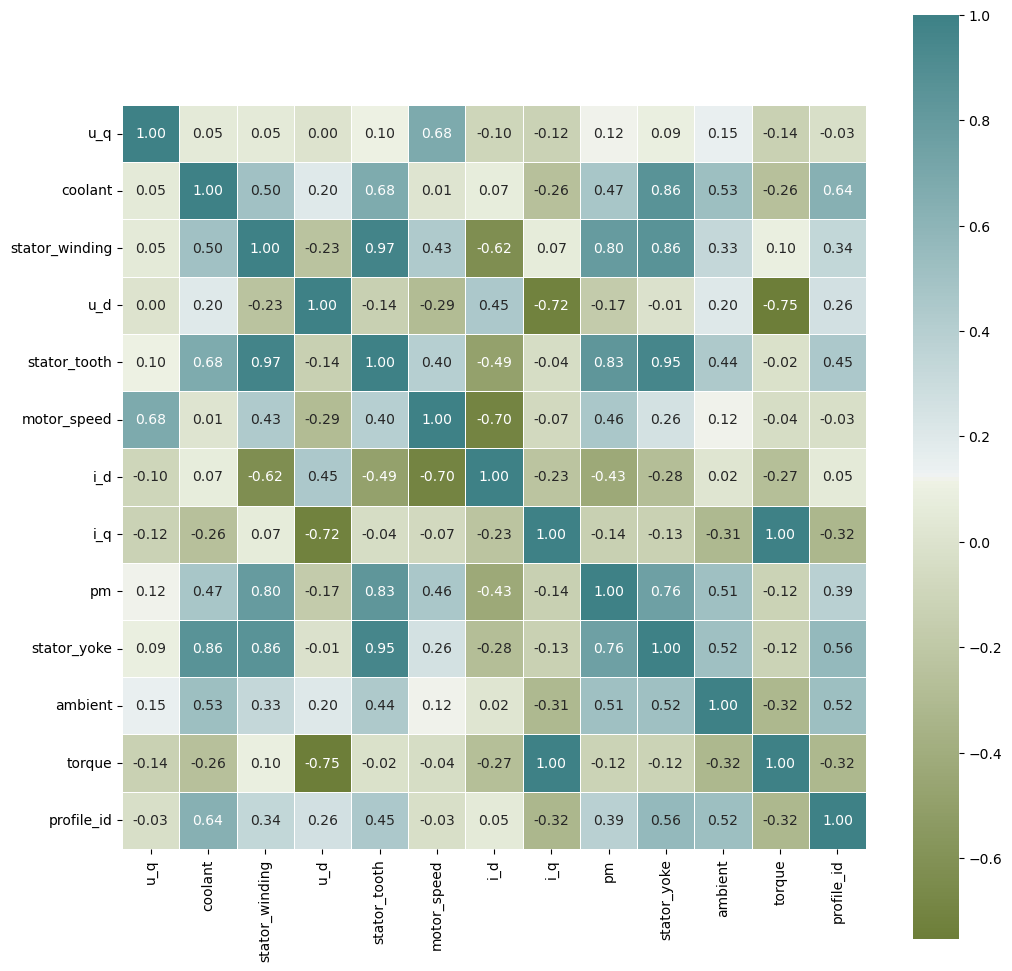

In [106]:
#correlation map
f,ax=plt.subplots(figsize=(12,12))
corr=motor.corr()

sns.heatmap(corr, annot=True, linewidths=.5, fmt='.2f', 
            mask= np.zeros_like(corr,dtype='bool'), 
            cmap=sns.diverging_palette(100,200,as_cmap=True), 
            square=True, ax=ax)

plt.show()

Profil ID abgebildet aber Korrelation nicht sinnvoll

Temperaturen untereinander korrelieren miteinander

Strom ist an Torque gekoppelt;

Hächste Korrelation zwischen pm außerhalb von anderen Temp ist id und motorspeed

In [107]:
motor["power"] = motor["u_d"] * motor["i_d"] + motor["u_q"] * motor["i_q"]
corr_matrix = motor.corr(numeric_only=True)
corr_matrix["power"].sort_values(ascending=False)

power             1.000000
torque            0.754997
i_q               0.717291
motor_speed       0.281237
stator_winding    0.267866
pm                0.184473
stator_tooth      0.165199
stator_yoke       0.020797
u_q              -0.049955
coolant          -0.198902
ambient          -0.209774
profile_id       -0.252816
i_d              -0.490677
u_d              -0.992326
Name: power, dtype: float64

Test die Leistung noch als Korrelation zu pm nicht sinnvoll; nur 0,18

Aktuell keinen neuen Werte eingefügt!

### 4. Prepare the Data

1. Write functions for all data transformations you apply.
2. Clean the data.
    - remove outliers
    - fill in missing values
3. Select important features (drop attributes that provide no useful information for the task).
4. Use feature engineering.
    - decompose categorical features
    - add promising transformations for features
    - aggregate features into promissing new features
5. Use feature scaling (standardize or normalize features).

In [108]:
# Labels vorbereiten
motor = strat_train_set.drop("pm", axis=1) # drop pm for training set
motor__pm_labels = strat_train_set["pm"].copy()

No Missing values, deswegen keine daten auffüllen

In [109]:
# Daten bereinigen von missleading Information
motor = motor.drop("coolant", axis=1) 
motor = motor.drop("stator_winding", axis=1)
motor = motor.drop("stator_tooth", axis=1)
motor = motor.drop("stator_yoke", axis=1)
motor = motor.drop("ambient", axis=1)
motor = motor.drop("profile_id", axis=1)
motor.head()

,u_q,u_d,motor_speed,i_d,i_q,torque
486400,73.499413,-0.246484,1499.983521,-2.000962,1.097150,-2.366589e-02
724527,70.820196,-3.026034,1495.647860,-2.659218,4.360475,2.173315e+00
641872,-0.174199,3.290139,0.002076,-2.000971,1.097257,-1.603729e-211
108384,4.176036,1.483652,99.974022,-1.999888,1.095639,2.330701e-01
882919,107.053965,-76.085422,3499.971770,-74.765850,61.168734,5.000000e+01


Dropen Temperaturen, weil missleading und Profile ID weil keinen einfluss

In [114]:
num_pipeline = Pipeline([
        ('minmax_scaler', MinMaxScaler()),
    ])

motor_tr = num_pipeline.fit_transform(motor)
motor_tr

array([[0.62396032, 0.49917805, 0.28292797, 0.99261709, 0.49488623,
        0.4856284 ],
       [0.60703838, 0.48860943, 0.28223709, 0.99024974, 0.50036957,
        0.48995767],
       [0.15863741, 0.51262528, 0.0439086 , 0.99261706, 0.49488641,
        0.48567504],
       ...,
       [0.70788929, 0.12814553, 0.84064096, 0.52234524, 0.58391556,
        0.57926196],
       [0.32832825, 0.9870501 , 0.66746307, 0.33124722, 0.29838211,
        0.26803635],
       [0.16286624, 0.51005485, 0.04390885, 0.99261665, 0.49488605,
        0.48567504]])

MinMax benutzt weil für ANN sinnvoll und für Random Forrest egal

imputor und attribus_adder weggelassen weil keine Werte hinzugefügt

### 5. Select and Train your Models

1. Learn the basics about the models you've been assigned.
2. Select a 3rd model on your own. Use criteria for your selection.
3. Make a plan for training and evaluation of the models.
4. Build your models (select meaningful values for the model parameters).
5. Train your models with the training set.
6. Measure and compare the performance of your models (use N-fold cross-validation).
7. Analyze the most significant parameters for each model.
8. Analyze the types of errors the models make.

### 6. Fine-Tune your Models

1. Fine-tune the hyperparameters using cross-validation.
    - treat your data transformation choices as hyperparameters, especially when you are not sure about them. (e.g. if you are not sure whether to replace missing values with zeros or with the median value, or to just drop the rows.)
    - use grid search and random search $\to$ compare and evaluate the results.
2. Compare the results of all three models after the fine-tuning process to determine the best hyperparameters.
3. Select a final model and measure its performance on the test set to estimate the generalization error.
    - dont tweak your model after measuring the generalization error: you would just start overfitting the test set.
4. Document the results of the examined models. Pay particular attention to the final model.

### 7. Present Your Solution

1. Document what you have done.
    - write a summary of the results in a new, final section
    - explain why your solution achieves the task objective
2. Create a nice presentation.
    - make sure to highlight the big picture first
    - make sure you explain the assigned model in detail to your fellow students
    - dont forget to present interesting points you noticed along the way
    - list your assumptions and your systems limitations
    - ensure your key findings are communicated